In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.metrics import pairwise_distances
import zipfile
import requests
import io
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.neighbors import NearestNeighbors



C:\Users\T-Gamer\AppData\Local\Temp\ipykernel_14220\994199711.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
# Comando para baixar os dados (comentado)
# !wget https://files.grouplens.org/datasets/movielens/ml-1m.zip -O ml-1m.zip

# Descompactando o arquivo
# with zipfile.ZipFile('ml-1m.zip', 'r') as zip_ref:
#     zip_ref.extractall('ml-1m')

# Carregando os dados
data_path = 'ml-1m/'
ratings = pd.read_csv(data_path + 'ratings.dat', sep='::', engine='python', names=['user_id', 'movie_id', 'rating', 'timestamp'], encoding='latin-1')
movies = pd.read_csv(data_path + 'movies.dat', sep='::', engine='python', names=['movie_id', 'title', 'genres'], encoding='latin-1')


Número de avaliações: 1000209
Número de usuários: 6040
Número de filmes: 3706


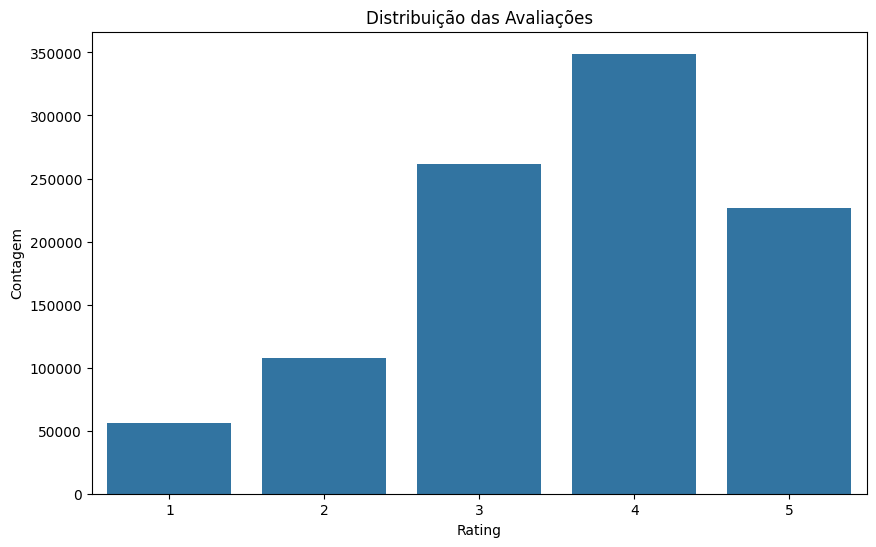

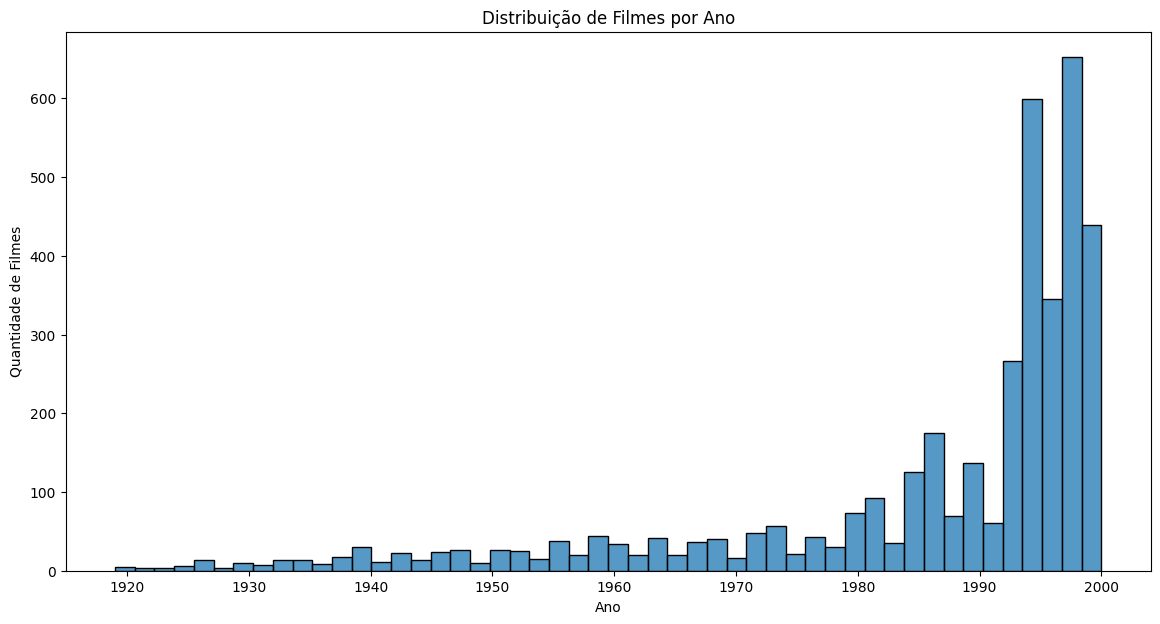

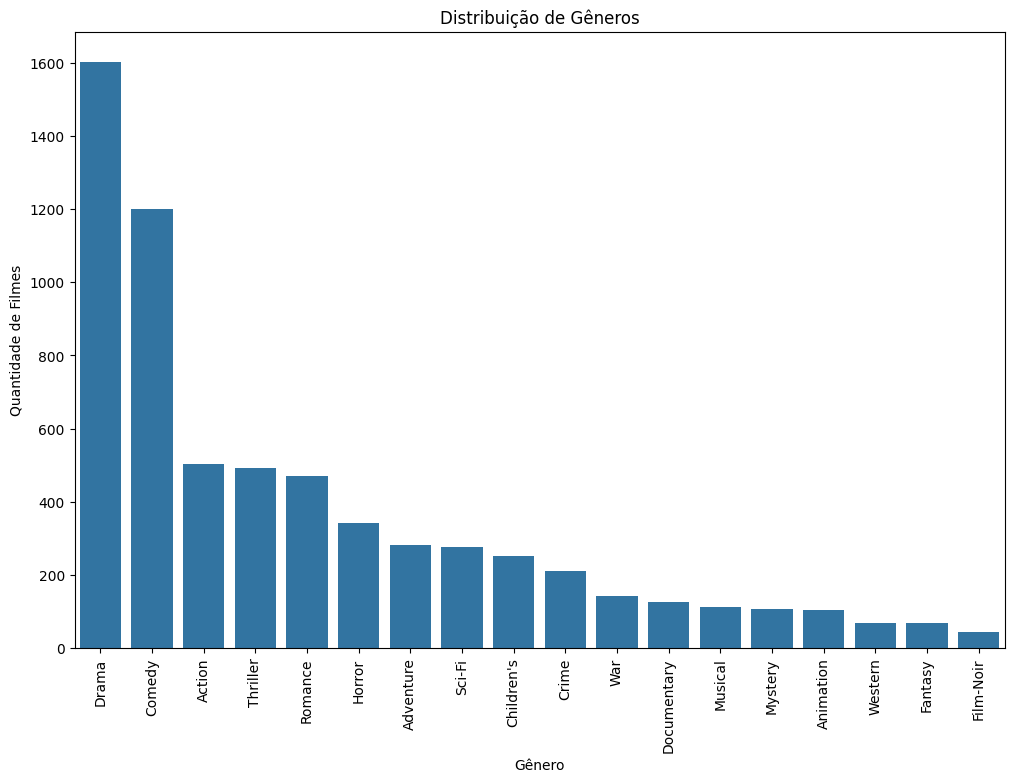

In [3]:
# Informações básicas
print(f'Número de avaliações: {ratings.shape[0]}')
print(f'Número de usuários: {ratings["user_id"].nunique()}')
print(f'Número de filmes: {ratings["movie_id"].nunique()}')

# Distribuição das avaliações
plt.figure(figsize=(10, 6))
sns.countplot(x='rating', data=ratings)
plt.title('Distribuição das Avaliações')
plt.xlabel('Rating')
plt.ylabel('Contagem')
plt.show()

# Filmes por ano
movies['year'] = movies['title'].str.extract(r'\((\d{4})\)')
movies['year'] = movies['year'].astype(float)
plt.figure(figsize=(14, 7))
sns.histplot(movies['year'].dropna(), bins=50, kde=False)
plt.title('Distribuição de Filmes por Ano')
plt.xlabel('Ano')
plt.ylabel('Quantidade de Filmes')
plt.show()

# Análise de gêneros
genres = movies['genres'].str.get_dummies('|')
genres_sum = genres.sum().sort_values(ascending=False)
plt.figure(figsize=(12, 8))
sns.barplot(x=genres_sum.index, y=genres_sum.values)
plt.title('Distribuição de Gêneros')
plt.xlabel('Gênero')
plt.ylabel('Quantidade de Filmes')
plt.xticks(rotation=90)
plt.show()


In [4]:
# Verificando duplicados
print(f'Duplicados em ratings: {ratings.duplicated().sum()}')
print(f'Duplicados em movies: {movies.duplicated().sum()}')

# Normalizando os dados de ratings
scaler = StandardScaler()
ratings_scaled = scaler.fit_transform(ratings[['rating']])


Duplicados em ratings: 0
Duplicados em movies: 0


In [5]:
# Criando matriz de distâncias
user_movie_matrix = ratings.pivot(index='user_id', columns='movie_id', values='rating')


In [6]:
# Check if file user_movie_matrix_filled exists
try:
    user_movie_matrix_filled = pd.read_csv('user_movie_matrix_filled.csv')
    print('user_movie_matrix_filled.csv loaded')

except:
    # Preencher valores NaN com 0 temporariamente para calcular similaridade
    user_movie_matrix_filled = user_movie_matrix.fillna(0)

    # Calcular a similaridade dos usuários usando similaridade do cosseno
    user_similarity = cosine_similarity(user_movie_matrix_filled)

    # Função para prever a avaliação de um filme para um usuário com base em usuários semelhantes
    def predict_rating(user_id, movie_id):
        
        
        # Similaridade do usuário atual com todos os outros usuários
        sim_scores = user_similarity[user_id - 1]

        # Obter as avaliações dos outros usuários para o filme
        ratings = user_movie_matrix[movie_id]
        
        # Excluir usuários que não avaliaram o filme (ratings NaN)
        non_nan_ratings = ratings.dropna()
        
        # Similaridade dos usuários que avaliaram o filme (ajustar índice para 0-based)
        sim_scores = sim_scores[non_nan_ratings.index - 1]
        
        # Pesos são as similaridades
        weights = sim_scores
        
        # Avaliações ponderadas
        weighted_ratings = non_nan_ratings * weights
        
        # Predizer a avaliação como a média ponderada das avaliações
        if weights.sum() > 0:
            return weighted_ratings.sum() / weights.sum()
        else:
            return np.nan

    # Preencher valores NaN na matriz de avaliações
    user_movie_matrix_filled = user_movie_matrix.copy()

    for user_id in user_movie_matrix.index:
        for movie_id in user_movie_matrix.columns:
            if pd.isna(user_movie_matrix.loc[user_id, movie_id]):
                predicted_rating = predict_rating(user_id, movie_id)
            user_movie_matrix_filled.loc[user_id, movie_id] = predicted_rating
    
    # Save user_movie_matrix_filled
    user_movie_matrix_filled.to_csv('user_movie_matrix_filled.csv')


user_movie_matrix_filled.csv loaded


In [7]:
user_movie_matrix_filled.index = user_movie_matrix_filled.index + 1
user_movie_matrix_filled.index.name = 'user_id'
user_movie_matrix_filled.columns.name = 'movie_id'

In [8]:
# Fill NaN values with mean rating of each movie
user_movie_matrix_filled = user_movie_matrix_filled.apply(lambda x: x.fillna(x.mean()), axis=0)

### K-means


#### Find best number of clusters by elbow method


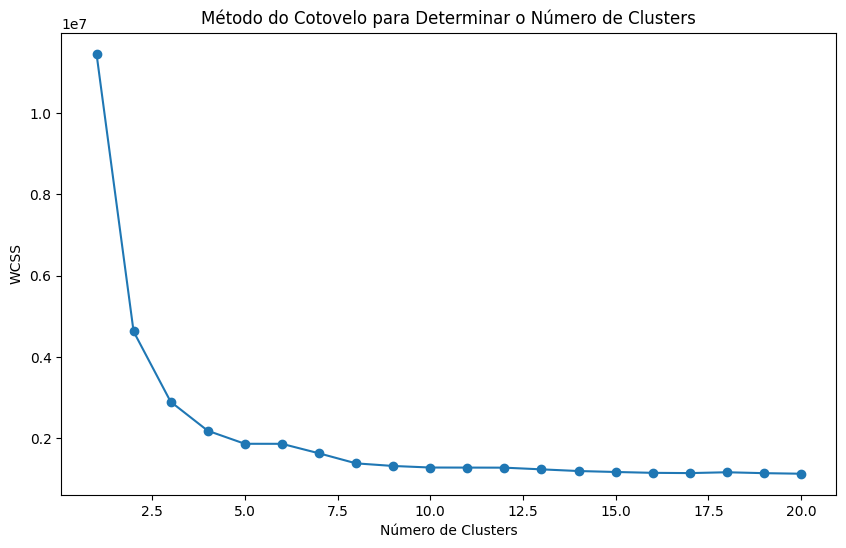

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

# Determinar o número ideal de clusters usando o método do cotovelo
wcss = []
for i in range(1, 21):
    kmeans = KMeans(n_clusters=i, random_state=42)
    kmeans.fit(user_movie_matrix_filled.T)
    wcss.append(kmeans.inertia_)

# Plotar o gráfico do método do cotovelo
plt.figure(figsize=(10, 6))
plt.plot(range(1, 21), wcss, marker='o')
plt.xlabel('Número de Clusters')
plt.ylabel('WCSS')
plt.title('Método do Cotovelo para Determinar o Número de Clusters')
plt.show()


In [10]:
kmeans = KMeans(n_clusters=3, random_state=42)
kmeans_labels = kmeans.fit_predict(user_movie_matrix_filled.T)

C:\Users\T-Gamer\AppData\Local\Temp\ipykernel_14220\1454849804.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=cluster_counts.index, y=cluster_counts.values, palette='viridis')


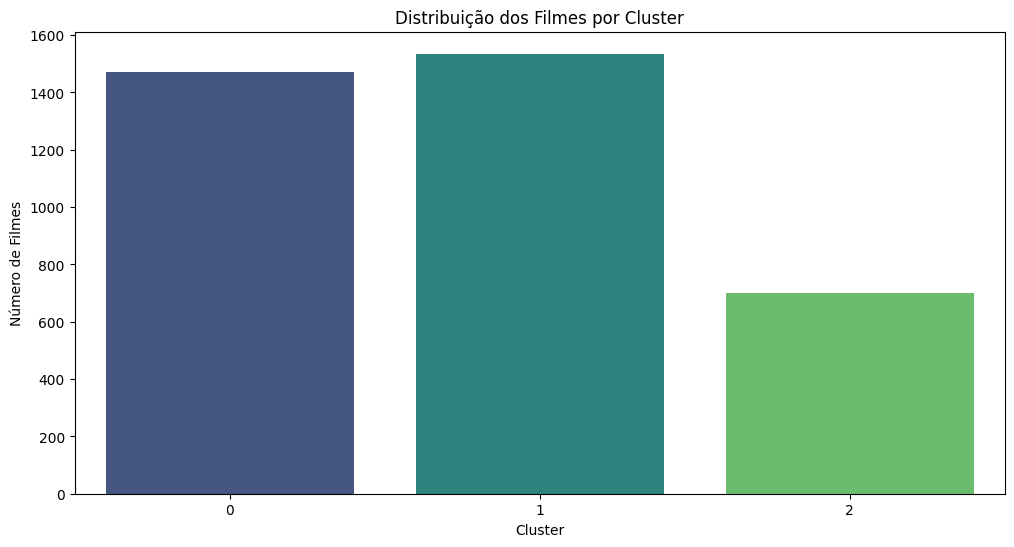

In [11]:
# Adicionar labels aos filmes
clustered_movies = pd.DataFrame({'movie_id': user_movie_matrix_filled.T.index, 'cluster': kmeans_labels})

clustered_movies['movie_id'] = clustered_movies['movie_id'].astype(int)

# Mesclar com os dados dos filmes para adicionar títulos
clustered_movies = pd.merge(clustered_movies, movies, on='movie_id')

# Contagem de filmes por cluster
cluster_counts = clustered_movies['cluster'].value_counts().sort_index()

# Gráfico de barras para distribuição dos clusters
plt.figure(figsize=(12, 6))
sns.barplot(x=cluster_counts.index, y=cluster_counts.values, palette='viridis')
plt.xlabel('Cluster')
plt.ylabel('Número de Filmes')
plt.title('Distribuição dos Filmes por Cluster')
plt.show()

### DBSCAN


#### Find best parameters


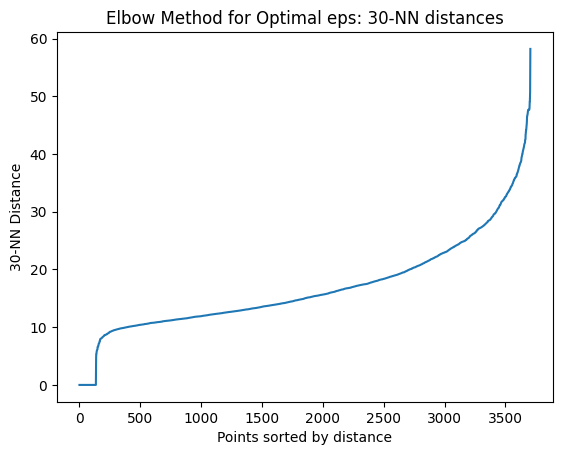

In [12]:
# Calculate k-nearest neighbors distances
def calculate_knn_distances(data, k):
    neigh = NearestNeighbors(n_neighbors=k)
    neigh.fit(data)
    distances, _ = neigh.kneighbors(data)
    return distances[:, -1]

# Function to find the "knee" in the distances curve
def find_eps_knee(distances):
    x = np.arange(len(distances))
    plt.plot(x, np.sort(distances))
    plt.xlabel('Points sorted by distance')
    plt.ylabel(f'{k}-NN Distance')
    plt.title(f'Elbow Method for Optimal eps: {k}-NN distances')
    plt.show()

    knee_idx = np.argmax(np.diff(distances, 2)) + 2
    knee_eps = np.sort(distances)[knee_idx]

    return knee_eps

# Example usage with your data (assuming user_movie_matrix_filled.T as data)
k = 30  # Choose the number of nearest neighbors (k)
distances = calculate_knn_distances(user_movie_matrix_filled.T, k)
optimal_eps = find_eps_knee(distances)



C:\Users\T-Gamer\AppData\Local\Temp\ipykernel_14220\328631276.py:24: FutureWarning: The provided callable <function sum at 0x000002970F02D080> is currently using DataFrameGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  pivot_table = results.pivot_table(index='min_samples', columns='eps', values='n_clusters', aggfunc=np.sum)


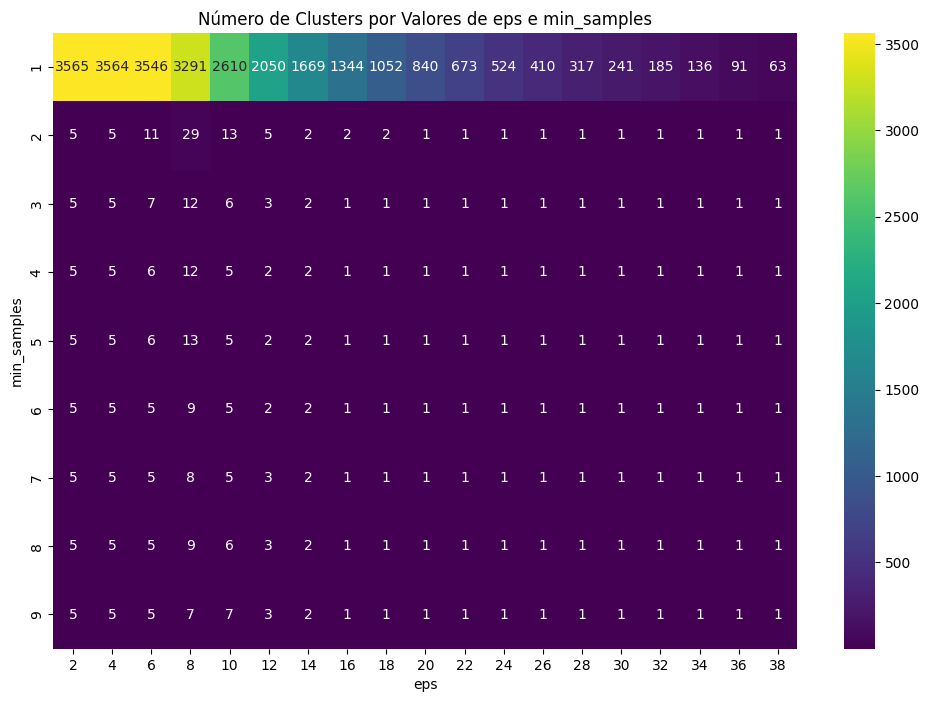

C:\Users\T-Gamer\AppData\Local\Temp\ipykernel_14220\328631276.py:36: FutureWarning: The provided callable <function sum at 0x000002970F02D080> is currently using DataFrameGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  pivot_table = results.pivot_table(index='min_samples', columns='eps', values='n_noise', aggfunc=np.sum)


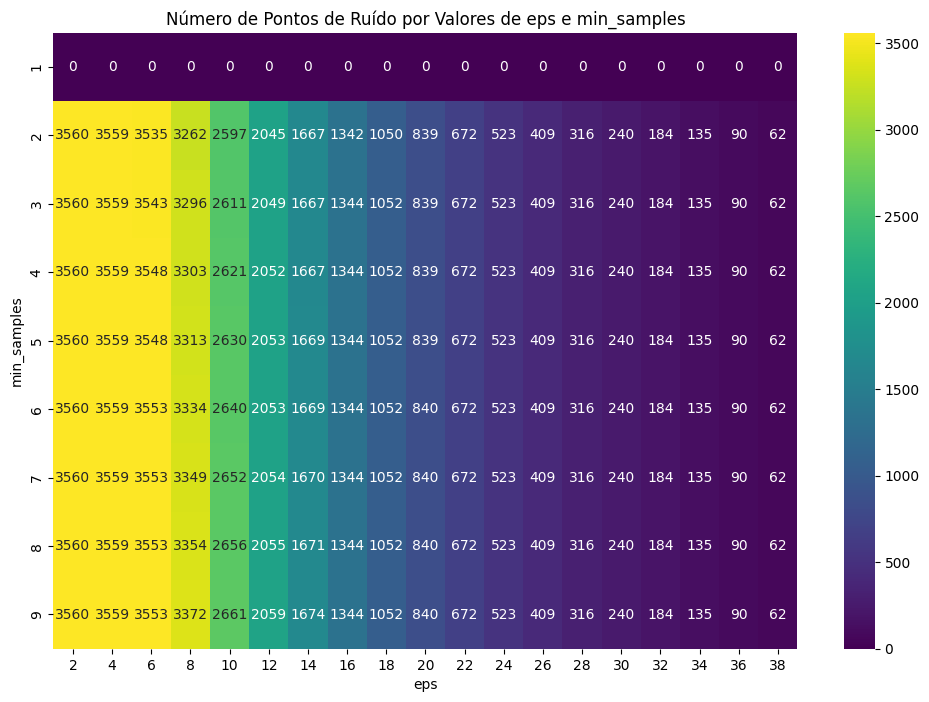

In [13]:
# Definir os intervalos de valores para eps e min_samples
eps_values = np.arange(2, 40, 2)
min_samples_values = np.arange(1, 10, 1)

# Criar um DataFrame para armazenar os resultados
results = pd.DataFrame(columns=['eps', 'min_samples', 'n_clusters', 'n_noise'])

# Testar diferentes combinações de eps e min_samples
for eps in eps_values:
    for min_samples in min_samples_values:
        dbscan = DBSCAN(eps=eps, min_samples=min_samples, metric='euclidean')
        dbscan_labels = dbscan.fit_predict(user_movie_matrix_filled.T)
        
        # Contar o número de clusters e pontos de ruído
        n_clusters = len(set(dbscan_labels)) - (1 if -1 in dbscan_labels else 0)
        n_noise = list(dbscan_labels).count(-1)
        
        # Adicionar os resultados ao DataFrame
        results = pd.concat([results, pd.DataFrame({'eps': [eps], 'min_samples': [min_samples], 'n_clusters': [n_clusters], 'n_noise': [n_noise]})], ignore_index=True)



# Visualizar os resultados usando um heatmap
pivot_table = results.pivot_table(index='min_samples', columns='eps', values='n_clusters', aggfunc=np.sum)
pivot_table = pivot_table.astype(int)


plt.figure(figsize=(12, 8))
sns.heatmap(pivot_table, annot=True, fmt="d", cmap='viridis')
plt.title('Número de Clusters por Valores de eps e min_samples')
plt.xlabel('eps')
plt.ylabel('min_samples')
plt.show()

# Visualize the number of noise points
pivot_table = results.pivot_table(index='min_samples', columns='eps', values='n_noise', aggfunc=np.sum)
pivot_table = pivot_table.astype(int)

plt.figure(figsize=(12, 8))
sns.heatmap(pivot_table, annot=True, fmt="d", cmap='viridis')
plt.title('Número de Pontos de Ruído por Valores de eps e min_samples')
plt.xlabel('eps')
plt.ylabel('min_samples')
plt.show()

In [14]:
dbscan = DBSCAN(eps=14, min_samples=2, metric='euclidean')
dbscan_labels = dbscan.fit_predict(user_movie_matrix_filled.T)

### Agglomerative Clustering

In [15]:
hierarchical = AgglomerativeClustering(n_clusters=3, metric='cosine', linkage='average')
hierarchical_labels = hierarchical.fit_predict(user_movie_matrix_filled.T)

# Remoção de outliers ( labels = -1 no DBSCAN)

In [16]:
filtered_labels = dbscan_labels[dbscan_labels != -1]
filtered_distance_matrix = user_movie_matrix_filled.T[dbscan_labels != -1]

In [24]:
user_movie_matrix_filled

movie_id,1,2,3,4,5,6,7,8,9,10,...,3943,3944,3945,3946,3947,3948,3949,3950,3951,3952
user_id,,,,,,,,,,,,,,,,,,,,,
1,5.000000,3.189469,3.025825,2.792590,3.018756,3.863991,3.400692,3.054232,2.527631,3.511285,...,3.133303,2.021763,1.403759,2.196869,3.503134,3.635667,4.074371,3.786554,3.943441,3.802202
2,4.151216,3.175182,2.976003,2.738930,2.989198,3.878911,3.363330,2.984787,2.657994,3.548841,...,3.147774,2.129961,1.355328,2.249059,3.542487,3.606221,4.095769,3.766971,3.897369,3.792803
3,4.167400,3.187896,3.005032,2.746573,2.969750,3.876332,3.370523,2.975446,2.623964,3.552135,...,3.127960,2.120191,1.427376,2.318851,3.562507,3.655865,4.122580,3.786705,3.893910,3.772158
4,4.157709,3.159143,2.960569,2.686295,2.910095,3.879262,3.331028,3.015004,2.670830,3.558428,...,3.157419,2.015117,1.424093,2.327993,3.731991,3.619142,4.115522,3.822557,3.911425,3.763755
5,4.136221,3.108889,2.932356,2.689030,2.915662,2.000000,3.275491,2.972951,2.530435,3.464918,...,3.154884,2.033772,1.387641,2.139077,3.486340,3.607480,4.120738,3.710989,3.866314,3.777887
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6036,4.155372,3.147571,2.934340,2.000000,2.932537,3.000000,3.304619,3.021037,2.552044,3.480768,...,3.162430,2.069482,1.368602,2.186879,3.580311,3.589002,4.120613,3.746521,3.858887,3.772254
6037,4.153702,3.118336,2.906752,2.674570,2.899562,3.851099,3.280968,2.988713,2.539968,3.456326,...,3.133292,2.145946,1.329180,2.178135,3.589145,3.565273,4.099600,3.706962,3.981698,3.761367
6038,4.162005,3.163739,2.980363,2.764144,2.950460,3.859612,3.410091,2.994848,2.509366,3.482499,...,3.126110,2.313666,1.416016,2.214703,3.526824,3.612435,4.122514,3.810840,3.786232,3.769095


## Redução de dimensionalidade


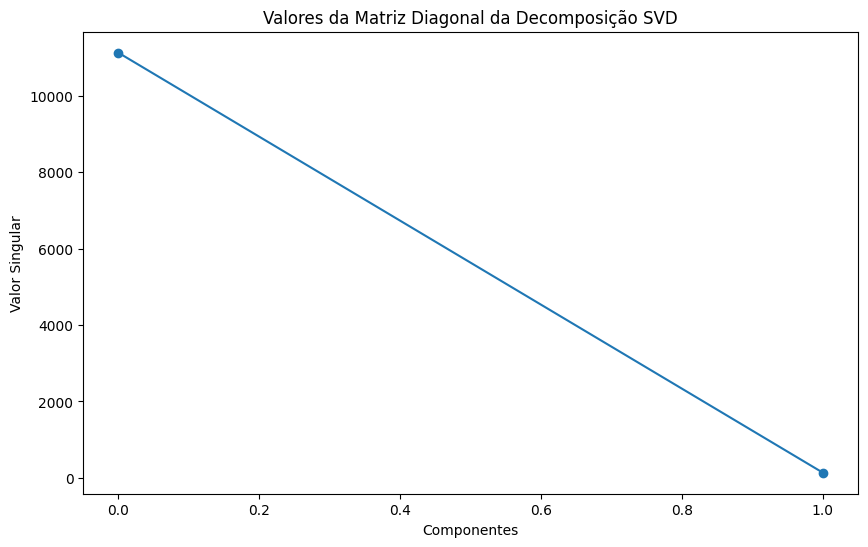

In [17]:
# PCA
pca = PCA(n_components=2)
reduced_data_pca = pca.fit_transform(filtered_distance_matrix)

# SVD
svd = TruncatedSVD(n_components=2)
reduced_data_svd = svd.fit_transform(filtered_distance_matrix)

# Plotando SVD
plt.figure(figsize=(10, 6))
plt.plot(svd.singular_values_, marker='o')
plt.title('Valores da Matriz Diagonal da Decomposição SVD')
plt.xlabel('Componentes')
plt.ylabel('Valor Singular')
plt.show()


# Interpretação dos clusters
